In [6]:
import os
import sys

import pandas as pd

import rbm_torch.utils.data_prep as dp
import rbm_torch.analysis.analysis_methods as am
from copy import copy

/home/jonah/anaconda3/envs/aptamer/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
mid_pd = pd.read_csv("./cov/cov_7_to_9_ct.csv")
low_pd = pd.read_csv("./cov/cov_4_to_6_ct.csv")
high_pd = pd.read_csv("./cov/cov_10_to_12_ct.csv")


cov_mid = mid_pd
cov_low = low_pd
cov_high = high_pd

all_seqs_pd = pd.merge(pd.merge(high_pd, mid_pd, how='outer', left_on='sequence', right_on='sequence'), low_pd, how='outer', left_on='sequence', right_on='sequence')

In [7]:
full_data = am.fetch_data([f"r{i}" for i in range(1, 13)], dir="./cov/raw_rounds/", threads=12)
count_millions = {}
for r in [f"r{i}" for i in range(1, 13)]:
    data = full_data[full_data["round"] == r]
    count_millions[r] = data["copy_num"].sum()/1000000

for r in [f"r{i}" for i in range(4, 13)]:
    all_seqs_pd[r] = all_seqs_pd[r].div(count_millions[r])


Process Time 13.37929916381836
Process Time 5.767950773239136
Process Time 0.3884248733520508
Process Time 0.3199951648712158
Process Time 1.386427640914917
Process Time 1.0071606636047363
Process Time 1.7183165550231934
Process Time 0.5766878128051758
Process Time 0.16481900215148926
Process Time 0.6254398822784424
Process Time 0.20380067825317383
Process Time 0.4289090633392334


In [16]:
def exclusive_rows(key_pd, query_pd, col_val):
    """returns rows in key pd that are not in query pd"""
    df_all = key_pd.merge(query_pd.drop_duplicates(), on=col_val, how='left', indicator=True)
    df_subset = copy(df_all[df_all['_merge'] == 'left_only'])
    return df_subset.drop("_merge", axis=1)

In [19]:
r1_data = full_data[full_data["round"] == "r1"]
r2_data = full_data[full_data["round"] == "r2"]

r2_only = exclusive_rows(r2_data, all_seqs_pd, "sequence")

r2_sub = exclusive_rows(r2_only, r1_data, "sequence")

In [13]:
r1_only.head()

,sequence,copy_num,round,assignment,r10,r11,r12,r7,r8,r9,r4,r5,r6,_merge
0,CCTTCGTGGCGCAATAGAGCCTAACTAATCGCCCCAACGT,1.0,r1,N/A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1,TGGGTGAAACGTAGGGCTGATTAGGGTCCTGGCAATAACC,1.0,r1,N/A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2,CGTTGGGTGGTATGTGCCGGTGTAATAAGATCAAATCATT,1.0,r1,N/A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,TGTTAGACGACCACGTATATGGTTCTTGGTCTCGCCCTCG,1.0,r1,N/A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,CCGGGACAGAGTTCTCGATAACGGCGCCTAAGGGAAACCC,1.0,r1,N/A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [20]:
r2_sub.index.__len__()

7621592

In [26]:
r7_data = full_data[full_data["round"] == "r7"]

r7_only = exclusive_rows(r7_data, all_seqs_pd, "sequence")

In [27]:
r7_only.index.__len__()

1899861

In [29]:
r7_sub = exclusive_rows(r7_only, r2_sub, "sequence")

In [30]:
r7_sub.index.__len__()

1871316

In [58]:
r7_sample = r7_sub.sample(100000)
r7_sample["fitness_value"] = [0.0001 for i in range(100000)]
# dp.dataframe_to_fasta(r7_sample, "./cov/mid_sample.fasta", count_key="fitness_value")

In [59]:
r2_sample = r2_sub.sample(100000)
r2_sample["fitness_value"] = [0.00001 for i in range(100000)]
# dp.dataframe_to_fasta(r2_sample, "./cov/bad_sample.fasta", count_key="fitness_value")

In [25]:
good_binders = am.fetch_data(["en_avg_g3"], dir="./cov/", molecule="dna")

Process Time 0.2580568790435791


In [43]:
pruned_r7_sample = prune_similar_sequences_df(r7_sample, good_binders, hamming_threshold=1)

Kept 70080 of 75000 in df1


In [60]:
r7_good_dists = prune_similar_sequences_df(r7_sample, good_binders, hamming_threshold=2, return_min_distances=True)

In [62]:
r2_good_dists = prune_similar_sequences_df(r2_sample, good_binders, hamming_threshold=2, return_min_distances=True)

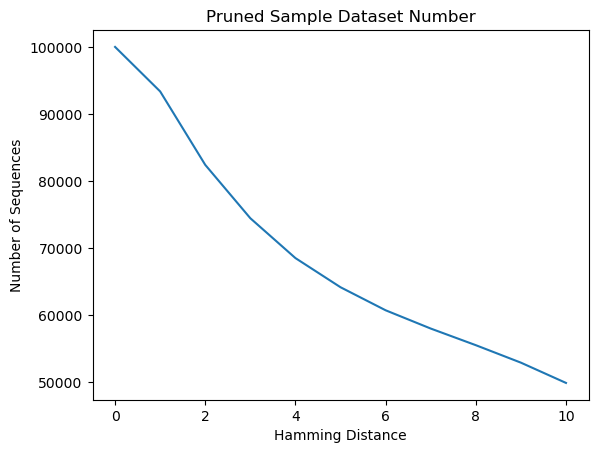

In [61]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1)
hamming_dists = np.arange(0, 11, 1).tolist()
number_of_seqs =[sum(i > d for i in r7_good_dists) for d in hamming_dists]
axs.plot(hamming_dists, number_of_seqs)
axs.set_xlabel("Hamming Distance")
axs.set_ylabel("Number of Sequences")
axs.set_title("Pruned Sample Dataset Number")
plt.show()

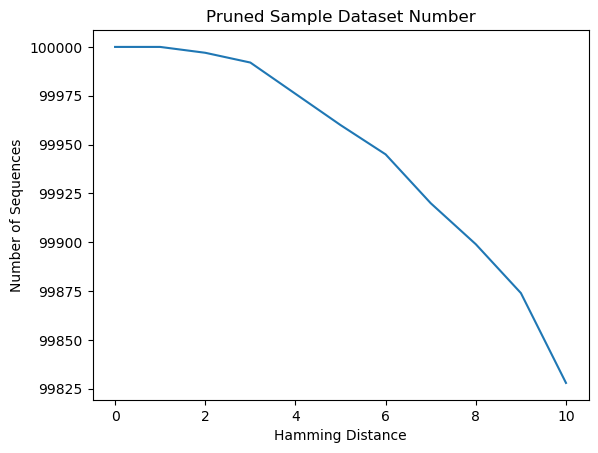

In [63]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1)
hamming_dists = np.arange(0, 11, 1).tolist()
number_of_seqs =[sum(i > d for i in r2_good_dists) for d in hamming_dists]
axs.plot(hamming_dists, number_of_seqs)
axs.set_xlabel("Hamming Distance")
axs.set_ylabel("Number of Sequences")
axs.set_title("Pruned Sample Dataset Number")
plt.show()

In [64]:
# Prepare sample of 75000 sequences with 2 mutations of more away from any sequence in the good binders
keep_r2 = r2_sample.iloc[:75000, :]

r7_keep = np.asarray(r7_good_dists) > 1
r7_select = r7_sample.iloc[r7_keep, :]
r7_select.reset_index(drop=True, inplace=True)

keep_r7 = r7_select.iloc[:75000, :]

dp.dataframe_to_fasta(keep_r7, "./cov/mid_sample.fasta", count_key="fitness_value")
dp.dataframe_to_fasta(keep_r2, "./cov/bad_sample.fasta", count_key="fitness_value")

In [54]:
from rbm_torch.utils.seq_utils import seq_to_cat
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import pairwise_distances_chunked
import numpy as np

def prune_similar_sequences_df(df1, df2, hamming_threshold=0, molecule="protein", return_min_distances=False):
    """generate subset of sequences in df1 that are at least x mutations away from all sequences in df2"""
    df1.reset_index(drop=True, inplace=True)
    df1_seqs = df1["sequence"].tolist()
    df1_index = df1.index.tolist()

    df1_cat = seq_to_cat(df1_seqs, molecule=molecule)
    X = df1_cat.numpy().astype(np.int8)

    df2.reset_index(drop=True, inplace=True)
    df2_seqs = df2["sequence"].tolist()
    df2_index = df2.index.tolist()

    df2_cat = seq_to_cat(df2_seqs, molecule=molecule)
    Y = df2_cat.numpy().astype(np.int8)

    seq_len = len(df1_seqs[0])


    def reduce_func(D_chunk, start):
        # print(D_chunk)
        return np.asarray(D_chunk).min(1).tolist()

    min_distances_chunked = pairwise_distances_chunked(X, Y, reduce_func=reduce_func, metric="hamming")

    mdists = []
    for n1 in min_distances_chunked:
        mdists += n1

    if return_min_distances:
        return [x* seq_len for x in mdists]
    else:
        keep = np.asarray(mdists)*seq_len > hamming_threshold

        dataframe = df1.iloc[keep, :]

        print(f"Kept {dataframe.index.__len__()} of {df1.index.__len__()} in df1")

        dataframe.reset_index(drop=True, inplace=True)
        return dataframe


In [ ]:
def enrichment_averge(df, round_names, min_diff=1, max_diff=None, diff_weights=None, round_weights=None):
    round_number = len(round_names)

    if max_diff is None:
        max_diff = round_number-1

    if diff_weights is None:
        diff_weights = [1. for x in range(min_diff, max_diff+1)]

    if round_weights is None:
        round_weights = [1. for x in range(len(round_names))]

    # first let's remove all the nan values in the dataframe, set nan values as the minimum normalized count for each round
    for r in round_names:
        df[r] = df[r].fillna(df[r].min())

    # Get fold value for round differences
    fold_keys = {diff: [] for diff in range(min_diff, max_diff+1)}
    for i in range(round_number):
        for j in range(round_number):
            if i >= j or j - i < min_diff or j - i > max_diff:
                continue
            fold_column_name = f"fold_{round_names[j]}v{round_names[i]}"
            fold_keys[j-i].append(fold_column_name)
            # fold_diffs.append(j-i)
            df[fold_column_name] = df[round_names[j]]/df[round_names[i]] * (round_weights[j] + round_weights[i])

    diff_keys = []
    for i in range(min_diff, max_diff+1):
        diff_avg_key = f"fold_diff{i}_avg"
        df[diff_avg_key] = df[fold_keys[i]].sum(axis=1).div(len(fold_keys[i])).mul(diff_weights[i-1])
        diff_keys.append(diff_avg_key)

    df["Final_Fold_Avg"] = df[diff_keys].sum(axis=1).div(len(diff_keys))

    return df